In [1]:
# load libs and modules
import numpy as np
import pandas as pd
import get_data
import preprocess_data

from sqlalchemy import create_engine
from MyCreds.mycreds import Capstone_AWS_RO       #from local site-packages

# for VIF
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

/Users/stuartong/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# import models to test
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


def run_regression(defined_model, target, train_df,validate_df,test_df,features_list):

    # import preprocessing and evaluation metrics
    from sklearn.metrics import r2_score
    from sklearn.metrics import mean_squared_error
    from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
    from yellowbrick.regressor import ResidualsPlot, PredictionError

    columns_to_drop = ['resale_price_norm',
                   'price_per_sq_ft_norm',
                   'price_per_sq_m_norm',
                   'price_per_sq_ft_per_lease_yr_norm',
                   'price_per_sq_m_per_lease_yr_norm',
                   ]
    targets = []
    targets.append(target)

    # get features and targets
    if len(features_list) == 0:
        features_list = [x for x in train_df.columns.tolist() if x not in columns_to_drop]
    else:
        features_list = features_list
    # print(features_list)
    X_train = train_df[features_list]
    y_train = train_df[targets]
    X_test = test_df[features_list]
    y_test = test_df[targets]
    X_val = validate_df[features_list]
    y_val = validate_df[targets]

    # #scale and transform values
    # sc = MinMaxScaler()
    # X_train = sc.fit_transform(X_train)
    # X_test = sc.transform(X_test)
    # X_val = sc.transform(X_val)

    # fit and predict the model
    reg = defined_model
    reg.fit(X_train,y_train)
    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)
    y_pred_val = reg.predict(X_val)

    # evaluate model
    # get R2 scores
    score_train = r2_score(y_train,y_pred_train)
    score_val = r2_score(y_val,y_pred_val)
    score_test = r2_score(y_test,y_pred_test)
    
    # get mse
    mse_train = mean_squared_error(y_train,y_pred_train)
    mse_val = mean_squared_error(y_val,y_pred_val)
    mse_test = mean_squared_error(y_test,y_pred_test)

    # print results
    r2_results = f'Dependent Variable:{target} \nR2 Scores: \nTrain:{score_train:.3f} \nValidation:{score_val:.3f}\nTest:{score_test:.3f}\nMSE: \nTrain:{mse_train:.3f}\nValidation:{mse_val:.3f} \nTest:{mse_test:.3f}\nIntercept:${reg.intercept_[0]:.2f}'
    print (r2_results)
    if str(type(reg)) == "<class 'sklearn.linear_model._base.LinearRegression'>":
        reg_coef = pd.DataFrame(reg.coef_,columns = features_list)
        
        # get residual plots
        # yellow brick only works with linear regressions it seems
        model = defined_model
        visualizer = ResidualsPlot(model)
        visualizer.fit(X_train, y_train)  
        visualizer.score(X_test, y_test)
        visualizer.show()
    else:
        reg_coef = pd.DataFrame(reg.coef_.reshape(1,-1),columns = features_list)

    return reg_coef.T.round(3).sort_values(by=0,ascending=False)

In [3]:
# get data with location features - shorter time frame (15 years - 441k data points)
train_df_dl,validate_df_dl,test_df_dl = get_data.get_data('resale_location_features',2007,2015,2016,2018,2019)

Getting Training Data
Training Data Done
Getting Validate Data
Validate Data Done
Getting Test Data
Test Data Done


In [4]:
one_hot_encode = ['town','flat_model']

train_df = preprocess_data.get_features_targets(train_df_dl,one_hot_encode)
test_df = preprocess_data.get_features_targets(test_df_dl,one_hot_encode)
validate_df = preprocess_data.get_features_targets(validate_df_dl,one_hot_encode)

Dependent Variable:price_per_sq_m_per_lease_yr_norm 
R2 Scores: 
Train:0.901 
Validation:0.844
Test:0.780
MSE: 
Train:29.312
Validation:61.886 
Test:77.196
Intercept:$513.57


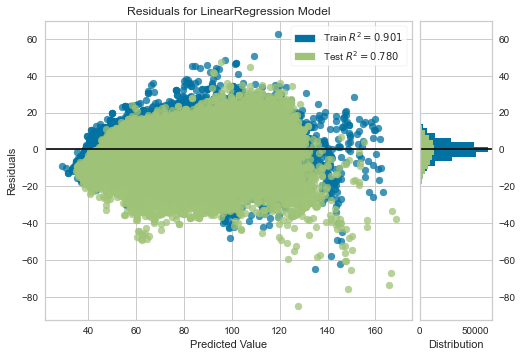

,0
flat_model_terrace,53.367
dist_to_con_area_id_52,9.496
flat_model_premium_maisonette,9.392
dist_to_con_area_id_48,8.435
dist_to_con_area_id_167,6.927
...,...
town_yishun,-18.539
town_sembawang,-18.691
town_bukit_panjang,-19.046
town_bukit_timah,-20.584


In [5]:
lr = LinearRegression()
features_list = []
run_regression(lr,'price_per_sq_m_per_lease_yr_norm',train_df,validate_df,test_df,features_list)

Dependent Variable:price_per_sq_m_per_lease_yr_norm 
R2 Scores: 
Train:0.884 
Validation:0.818
Test:0.722
MSE: 
Train:34.177
Validation:72.408 
Test:97.412
Intercept:$218.19


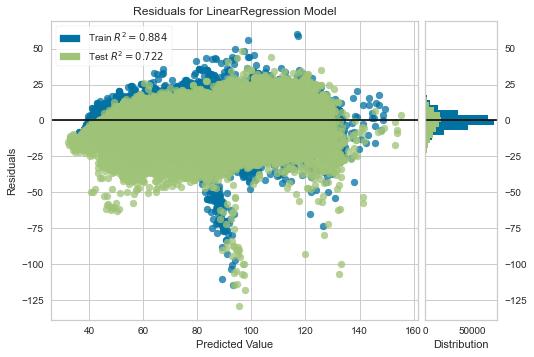

,0
dist_to_con_area_id_52,8.607
dist_to_con_area_id_48,7.536
dist_to_con_area_id_102,6.295
dist_to_con_area_id_191,5.911
dist_to_con_area_id_163,5.603
...,...
dist_to_con_area_id_47,-5.501
dist_to_con_area_id_57,-5.914
dist_to_central_business_district,-6.729
dist_to_con_area_id_51,-8.380


In [6]:
one_hot_encode = []

train_df = preprocess_data.get_features_targets(train_df_dl,one_hot_encode)
test_df = preprocess_data.get_features_targets(test_df_dl,one_hot_encode)
validate_df = preprocess_data.get_features_targets(validate_df_dl,one_hot_encode)

lr = LinearRegression()
features_list = []
run_regression(lr,'price_per_sq_m_per_lease_yr_norm',train_df,validate_df,test_df,features_list)

Dependent Variable:price_per_sq_m_per_lease_yr_norm 
R2 Scores: 
Train:0.891 
Validation:0.825
Test:0.737
MSE: 
Train:32.123
Validation:69.667 
Test:92.228
Intercept:$181.98


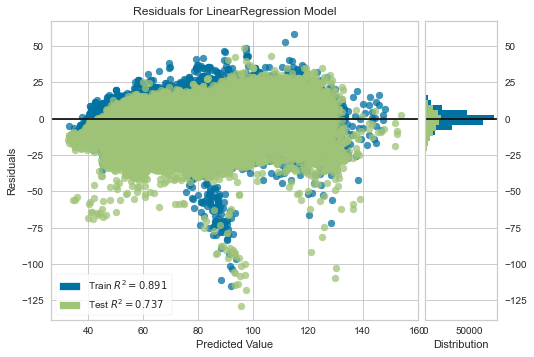

,0
flat_type_multi_generation,11.156
dist_to_con_area_id_48,9.397
dist_to_con_area_id_52,7.391
dist_to_con_area_id_65,5.519
flat_type_executive,5.347
...,...
flat_type_4_room,-7.657
dist_to_con_area_id_237,-8.285
dist_to_con_area_id_51,-8.371
flat_type_3_room,-13.573


In [7]:
one_hot_encode = ['flat_type']

train_df = preprocess_data.get_features_targets(train_df_dl,one_hot_encode)
test_df = preprocess_data.get_features_targets(test_df_dl,one_hot_encode)
validate_df = preprocess_data.get_features_targets(validate_df_dl,one_hot_encode)

lr = LinearRegression()
features_list = []
run_regression(lr,'price_per_sq_m_per_lease_yr_norm',train_df,validate_df,test_df,features_list)

In [ ]:
train_df.columns.tolist()

In [ ]:
# get clusters for conservation areas
engine = create_engine(f'postgresql+psycopg2://{Capstone_AWS_RO.username}:{Capstone_AWS_RO.password}@{Capstone_AWS_RO.host}/Capstone', echo=False)
sql_alc_cnxn = engine.connect()

meters = 400

sql_query = f'''
SELECT
	DISTINCT ON (cluster_id) cluster_id,
	"OBJECTID",
	"GROUP_NAME"
	FROM
(
SELECT
	"OBJECTID",
	"GROUP_NAME",
	ST_ClusterDBSCAN(geometry, eps := {meters/111139}, minpoints:=1) over () as cluster_id
FROM conservation_areas
) a
ORDER BY
cluster_id,
"OBJECTID"
'''
con_area_clusters = pd.read_sql(sql_query, sql_alc_cnxn)
con_area_clusters

lead_string = 'dist_to_con_area_id_'
con_id_to_keep = []
con_id_to_drop = []

# ids to keep - ie remove from list to drop
for i in con_area_clusters['OBJECTID']:
	con_id_to_keep.append(lead_string+str(i))
# con_id_to_keep

# ids to remove
for i in range(1,249):
    con_id_to_drop.append(lead_string+str(i))
# con_id_to_drop

to_drop = list(set(con_id_to_drop)-set(con_id_to_keep))

train_df = train_df.drop(columns=to_drop)
test_df = test_df.drop(columns=to_drop)
validate_df = validate_df.drop(columns=to_drop)


In [ ]:
combined = pd.concat([train_df,test_df,validate_df],ignore_index=True)

# check correlations to 
corr_df = combined.corr()
corr_df = corr_df[['price_per_sq_m_norm']].sort_values(by='price_per_sq_m_norm')
print(corr_df.to_string())

In [ ]:
# Iteratively check for Multicollinearity

# exclude target variables
targets = [ 'resale_price_norm',
            'price_per_sq_ft_norm',
            'price_per_sq_ft_per_lease_yr_norm',
            'price_per_sq_m_norm',
            'price_per_sq_m_per_lease_yr_norm',]

# get initial features 
features = [x for x in combined.columns.tolist() if x not in targets]


def calc_vif(df,list_of_features):
    '''
    Function to check for multicollinearity
    '''
    from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[list_of_features])
    headers = df[list_of_features].columns.tolist()
    df = pd.DataFrame(scaled_data, columns=headers)

    # create VIF dataframe
    vif_df = pd.DataFrame()
    vif_df['feature'] = list_of_features
    vif_df['VIF'] = [variance_inflation_factor(df[list_of_features].values,i) for i in range(len(list_of_features))]

    return vif_df.round(3).sort_values(by='VIF',ascending=False)

check_vif = calc_vif(combined,features)

In [ ]:
check_vif[check_vif['VIF']>5].head(50)

In [ ]:
features.remove('dist_to_con_area_id_183') # similar to Sentosa
features.remove('dist_to_con_area_id_31') # similar to Hort Park
features.remove('dist_to_con_area_id_225') # similar to Hort Park
features.remove('dist_to_con_area_id_39') # similar to Dempsey Hill
features.remove('dist_to_con_area_id_239') # similar to Hort Park
features.remove('dist_to_con_area_id_250') # similar to CBD
features.remove('dist_to_con_area_id_249') # similar to Dempsey Hill
features.remove('dist_to_con_area_id_164') # similar to Orchard
features.remove('dist_to_con_area_id_13') # similar to Botanic Gardens
features.remove('dist_to_con_area_id_83') # similar to Hort Park
features.remove('dist_to_con_area_id_159') # similar to Hort Park
features.remove('dist_to_con_area_id_3') # similar to Arab St
features.remove('dist_to_con_area_id_109') # similar to Sixth Ave/Holland Village
features.remove('dist_to_con_area_id_62') # similar to Hort Park
features.remove('dist_to_con_area_id_35') # similar to Bishan Park
features.remove('dist_to_con_area_id_12') # similar to Tiong Bahru
features.remove('dist_to_con_area_id_240') # similar to id_106 Southern Ridges/Mount Faber
features.remove('dist_to_con_area_id_46') # similar to id_202 Novena area
features.remove('dist_to_con_area_id_36') # similar to id_1 seletar aerospace park 
features.remove('dist_to_con_area_id_59') # similar to id_254 - Sembawang Park


check_vif = calc_vif(combined,features)

In [ ]:
check_vif[check_vif['VIF']>5].head(50)

In [ ]:
features.remove('dist_to_con_area_id_153') # Not a POI
features.remove('dist_to_con_area_id_253') # China Town - high VIF
features.remove('dist_to_con_area_id_97') # Newton - high VIF
features.remove('dist_to_con_area_id_202') # Novena - high VIF
features.remove('dist_to_sentosa') # Sentosa - high VIF
features.remove('dist_to_con_area_id_115') # Keppel Bay Area - not really a POI high VIF
features.remove('dist_to_central_business_district') # high vif - could potentially add back 250?
features.remove('storey_range_max') # high vif - could potentially add back 250?

check_vif = calc_vif(combined,features)

In [ ]:
check_vif[check_vif['VIF']>5].head(50)

In [ ]:
features.remove('dist_to_botanic_gardens') # High VIF
features.remove('dist_to_con_area_id_67') # Rail Corridor - high VIF
features.remove('dist_to_con_area_id_32') # Spottiswoode - high VIF
features.remove('dist_to_con_area_id_168') # Ubin - high VIF
features.remove('dist_to_con_area_id_251') # Jalan Jurong Kechil - high VIF
features.remove('dist_to_thomson_ridge') # High VIF - close to lower piece (120)/macritchie (119)
features.remove('dist_to_con_area_id_106') # Mount Faber - high VIF
features.remove('dist_to_con_area_id_208') # Changi Village - high VIF
features.remove('dist_to_con_area_id_119') # Macritchie - high VIF


check_vif = calc_vif(combined,features)

In [ ]:
remove = check_vif[check_vif['VIF']>5].head(21).feature.tolist() 
for i in remove:
    features.remove(i)
check_vif = calc_vif(combined,features)

In [ ]:
check_vif[check_vif['VIF']>5].head(50)

In [ ]:
features.remove('nearest_hawker') # High VIF
features.remove('num_primary_schools_2km') # High VIF
features.remove('num_secondary_schools_2km') # High VIF

In [ ]:
check_vif = calc_vif(combined,features)

In [ ]:
check_vif[check_vif['VIF']>5]

In [ ]:
features.remove('n_rooms') # High VIF
features.remove('num_primary_schools_1km') # High VIF

check_vif = calc_vif(combined,features)


In [ ]:
check_vif[check_vif['VIF']>5]

In [ ]:
features.remove('num_hawker_1_5km') # High VIF
features.remove('num_transit_stations_1_5km') # High VIF
features.remove('nearest_transit_station') # High VIF

check_vif = calc_vif(combined,features)

In [ ]:
check_vif[check_vif['VIF']>5]

In [ ]:
features.remove('nearest_expressway') # High VIF
features.remove('num_secondary_schools_1km') # High VIF

check_vif = calc_vif(combined,features)

In [ ]:
check_vif[check_vif['VIF']>5]

In [ ]:
features.remove('num_preschools_1km') # High VIF
features.remove('score_primary_schools_2km') # High VIF
features.remove('num_supermarket_1_5km') # High VIF
features.remove('num_min_parks_2km') # High VIF


check_vif = calc_vif(combined,features)

In [ ]:
check_vif[check_vif['VIF']>5]

In [ ]:
features.remove('remaining_lease_years') # High VIF
features.remove('score_secondary_schools_2km') # High VIF
features.remove('num_healthcare_5km') # High VIF
features.remove('num_busstops_400m') # High VIF



check_vif = calc_vif(combined,features)

In [ ]:
check_vif[check_vif['VIF']>5]

In [ ]:
features

In [8]:
listfeats=['storey_range_min',
 'floor_area_sqm',
 'num_preschools_400m',
 'score_primary_schools_1km',
 'score_secondary_schools_1km',
 'num_healthcare_2km',
 'nearest_healthcare_clinc',
 'nearest_police',
 'nearest_fire',
 'num_maj_parks_1km',
 'num_maj_parks_2km',
 'nearest_maj_park',
 'num_min_parks_1km',
 'nearest_min_park',
 'num_waterbodies_100m',
 'num_waterbodies_500m',
 'nearest_waterbody',
 'nearest_supermarket',
 'num_wetmarket_1_5km',
 'nearest_wetmarket',
 'nearest_expressway_entrance_exit',
 'num_busstops_100m',
 'nearest_busstop',
 'num_taxistands_100m',
 'num_taxistands_400m',
 'nearest_taxistand',
 'score_stations_1_5km',
 'num_transit_exits_100m',
 'num_transit_exits_400m',
 'dist_to_nearest_transit_exit',
 'num_malls_1_5km',
 'nearest_mall']

features_list = listfeats


Dependent Variable:price_per_sq_m_per_lease_yr_norm 
R2 Scores: 
Train:0.709 
Validation:0.653
Test:0.558
MSE: 
Train:85.979
Validation:138.062 
Test:155.273
Intercept:$87.50


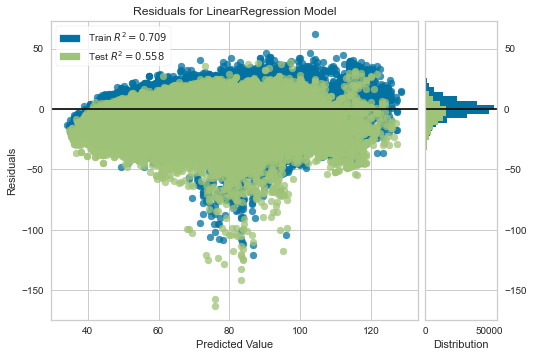

,0
num_taxistands_100m,2.898
num_wetmarket_1_5km,2.310
num_taxistands_400m,0.744
num_transit_exits_400m,0.526
storey_range_min,0.519
num_min_parks_1km,0.369
score_stations_1_5km,0.365
num_waterbodies_500m,0.210
num_maj_parks_2km,0.190
dist_to_nearest_transit_exit,0.003


In [9]:
one_hot_encode = []

train_df = preprocess_data.get_features_targets(train_df_dl,one_hot_encode)
test_df = preprocess_data.get_features_targets(test_df_dl,one_hot_encode)
validate_df = preprocess_data.get_features_targets(validate_df_dl,one_hot_encode)

model = LinearRegression()
run_regression(model,'price_per_sq_m_per_lease_yr_norm',train_df,validate_df,test_df,features_list)

In [18]:
one_hot_encode = []

train_df = preprocess_data.get_features_targets(train_df_dl,one_hot_encode)
test_df = preprocess_data.get_features_targets(test_df_dl,one_hot_encode)
validate_df = preprocess_data.get_features_targets(validate_df_dl,one_hot_encode)

model = SGDRegressor(loss='epsilon_insensitive',epsilon=0.5,alpha=0.001)
run_regression(model,'price_per_sq_m_per_lease_yr_norm',train_df,validate_df,test_df,features_list)

/Users/stuartong/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/stuartong/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:1228: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Dependent Variable:price_per_sq_m_per_lease_yr_norm 
R2 Scores: 
Train:-9078.030 
Validation:-6965.451
Test:-8079.367
MSE: 
Train:2681763.306
Validation:2770584.411 
Test:2836130.303
Intercept:$16.23


,0
num_wetmarket_1_5km,2.192
num_min_parks_1km,1.550
num_waterbodies_500m,0.994
num_busstops_100m,0.958
num_transit_exits_400m,0.899
num_taxistands_400m,0.868
score_stations_1_5km,0.802
storey_range_min,0.659
num_healthcare_2km,0.571
num_malls_1_5km,0.526


In [11]:
one_hot_encode = []

train_df = preprocess_data.get_features_targets(train_df_dl,one_hot_encode)
test_df = preprocess_data.get_features_targets(test_df_dl,one_hot_encode)
validate_df = preprocess_data.get_features_targets(validate_df_dl,one_hot_encode)

model = LinearSVR(C=1.0, epsilon=0.2)
run_regression(model,'price_per_sq_m_per_lease_yr_norm',train_df,validate_df,test_df,features_list)

/Users/stuartong/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Dependent Variable:price_per_sq_m_per_lease_yr_norm 
R2 Scores: 
Train:-1.857 
Validation:-0.939
Test:-0.957
MSE: 
Train:843.954
Validation:771.329 
Test:687.021
Intercept:$16.71


/Users/stuartong/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


,0
num_busstops_100m,4.631
num_wetmarket_1_5km,2.827
num_healthcare_2km,1.908
num_taxistands_400m,1.520
num_transit_exits_400m,1.354
num_waterbodies_500m,0.956
num_min_parks_1km,0.841
num_waterbodies_100m,0.840
storey_range_min,0.655
score_stations_1_5km,0.614


In [19]:
one_hot_encode = []

train_df = preprocess_data.get_features_targets(train_df_dl,one_hot_encode)
test_df = preprocess_data.get_features_targets(test_df_dl,one_hot_encode)
validate_df = preprocess_data.get_features_targets(validate_df_dl,one_hot_encode)

model = SVR(C=1.0, epsilon=0.3)
run_regression(model,'price_per_sq_m_per_lease_yr_norm',train_df,validate_df,test_df,features_list)

/Users/stuartong/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Dependent Variable:price_per_sq_m_per_lease_yr_norm 
R2 Scores: 
Train:0.752 
Validation:0.684
Test:0.568
MSE: 
Train:73.145
Validation:125.651 
Test:151.666
Intercept:$76.32


AttributeError: coef_ is only available when using a linear kernel

In [ ]:
# import models to test
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


def run_regression(defined_model, target, train_df,test_df,validate_df,features_list):

    # import preprocessing and evaluation metrics
    from sklearn.metrics import r2_score
    from sklearn.metrics import mean_squared_error
    from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
    from yellowbrick.regressor import ResidualsPlot, PredictionError

    columns_to_drop = ['resale_price_norm',
                   'price_per_sq_ft_norm',
                   'price_per_sq_m_norm',
                   'price_per_sq_ft_per_lease_yr_norm',
                   'price_per_sq_m_per_lease_yr_norm',
                   'storey_range_max',
                   'n_rooms',
                   'remaining_lease_years',
                   'floor_area_sqm',
                   'flat_model_model_a'
                   ]
    targets = []
    targets.append(target)

    # get features and targets
    # features = [x for x in train_df.columns.tolist() if x not in columns_to_drop]
    
    
    X_train = train_df[features_list]
    y_train = train_df[targets]
    X_test = test_df[features_list]
    y_test = test_df[targets]
    X_val = validate_df[features_list]
    y_val = validate_df[targets]

    # #scale and transform values
    # sc = MinMaxScaler()
    # X_train = sc.fit_transform(X_train)
    # X_test = sc.transform(X_test)
    # X_val = sc.transform(X_val)

    # fit and predict the model
    reg = defined_model
    reg.fit(X_train,y_train)
    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)
    y_pred_val = reg.predict(X_val)

    # evaluate model
    # get R2 scores
    score_train = r2_score(y_train,y_pred_train)
    score_test = r2_score(y_test,y_pred_test)
    score_val = r2_score(y_val,y_pred_val)

    # get mse
    mse_train = mean_squared_error(y_train,y_pred_train)
    mse_test = mean_squared_error(y_test,y_pred_test)
    mse_val = mean_squared_error(y_val,y_pred_val)

    # print results
    r2_results = f'Dependent Variable:{target} \nR2 Scores: \nTrain:{score_train:.3f} \nTest:{score_test:.3f}\nValidation:{score_val:.3f}\nMSE: \nTrain:{mse_train:.3f} \nTest:{mse_test:.3f}\nValidation:{mse_val:.3f}\nIntercept:${reg.intercept_[0]:.2f}'
    print (r2_results)
    reg_coef = pd.DataFrame(reg.coef_,columns = features_list)
    


    # get residual plots
    model = defined_model
    visualizer = ResidualsPlot(model)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)
    visualizer.show()

    return reg_coef.T.round(3).sort_values(by=0,ascending=False)

In [ ]:
# define some models
lr = LinearRegression()
lasso = Lasso(alpha=0.3)
ridge = Ridge()
elastic = ElasticNet()
svr = SVR(C=1.0, epsilon=0.2)
lsvr = LinearSVR(C=2.0, epsilon=0.2)

In [ ]:
lr = LinearRegression()
run_regression(lr,'resale_price_norm',train_df,test_df,validate_df,features_list)

In [ ]:
run_regression(lr,'price_per_sq_m_norm',train_df,test_df,validate_df,features_list)

In [ ]:
run_regression(lr,'price_per_sq_m_per_lease_yr_norm',train_df,test_df,validate_df,features_list)

In [ ]:
run_regression(Lasso(alpha=0.0005),'price_per_sq_m_per_lease_yr_norm',train_df,test_df,validate_df,features_list)

In [ ]:
run_regression(lsvr,'price_per_sq_m_per_lease_yr_norm',train_df,test_df,validate_df,features_list)